# Assignment: NYC taxi trip duration prediction

In this assignment, we are providing you the NYC-trip duration dataset. 

At some point or the other almost each one of us has used an Ola or Uber for taking a ride. **To improve the efficiency of taxi dispatching systems for such services, it is important to be able to predict how long a driver will have his taxi occupied.** If a dispatcher knew approximately when a taxi driver would be ending their current ride, they would be better able to identify which driver to assign to each pickup request.

You can download the dataset from the link given below and build a predictive model using that. Once you have built the model, submit the jupyter notebook and we will evaluate it.

**Independent Variables**

`id` - a unique identifier for each trip

`vendor_id` - a code indicating the provider associated with the trip record

`pickup_datetime` - date and time when the meter was engaged

`dropoff_datetime` - date and time when the meter was disengaged

`passenger_count` - the number of passengers in the vehicle (driver entered value)

`pickup_longitude` - the longitude where the meter was engaged

`pickup_latitude` - the latitude where the meter was engaged

`dropoff_longitude` - the longitude where the meter was disengaged

`dropoff_latitude` - the latitude where the meter was disengaged

`store_and_fwd_flag` - This flag indicates whether the trip record was held in vehicle memory before sending to the vendor because the vehicle did not have a connection to the server (Y=store and forward; N=not a store and forward trip)


**Target Varible**

`trip_duration` -  Duration of the trip in seconds

## Outline to model and predict 'trip duration' using Decision Tree
    
1. `Import Libraries`
2. `Prepare Data`
3. `Explore Data`
4. `Feature Analysis`
    <br>4.1 Create an elbow curve to select the optimal number of clusters
    <br>4.2 Clustering using K-Means and Assigning Clusters to Data
5. Feature Selection
    <br>5.1 Correlation of Independent Featues
6. `Model Building`
    <br>6.1 Plotting Decision Tree without using any external tool for Optimization such as Grid Search CV
    <br>6.2 Standardize and Apply Decision Tree algorithm for regression
    <br>6.3 Make predictions and evaluate output.
    <br>6.4 Evaluating the Prediction Accuracy
7. `Using  Gridsearch & Cross Validation appropriately.`
    <br>7.1 Import GridSearch CV and find CV results
    <br>7.2 Rerun DecisionTree Regressor based on Best Estimator

## 1. Import Libraries

In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import datetime
from scipy import stats

import warnings
warnings.filterwarnings("ignore")


%matplotlib inline

In [2]:
# Install 'haversine' library. This helps to find distance between two locations having Lat & Lon values.

!pip install haversine

In [3]:
from haversine import haversine, Unit

In [4]:
# Read NYC Tax trip duration data from the CSV file that is available from the same directory of this notebook

nyc_taxi_trip_df = pd.read_csv('Linear_Regression/nyc_taxi_trip_duration.csv')
nyc_taxi_trip_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id1080784,2,2016-02-29 16:40:21,2016-02-29 16:47:01,1,-73.953918,40.778873,-73.963875,40.771164,N,400
1,id0889885,1,2016-03-11 23:35:37,2016-03-11 23:53:57,2,-73.988312,40.731743,-73.994751,40.694931,N,1100
2,id0857912,2,2016-02-21 17:59:33,2016-02-21 18:26:48,2,-73.997314,40.721458,-73.948029,40.774918,N,1635
3,id3744273,2,2016-01-05 09:44:31,2016-01-05 10:03:32,6,-73.961670,40.759720,-73.956779,40.780628,N,1141
4,id0232939,1,2016-02-17 06:42:23,2016-02-17 06:56:31,1,-74.017120,40.708469,-73.988182,40.740631,N,848


In [5]:
nyc_taxi_trip_df.shape

(729322, 11)

In [6]:
nyc_taxi_trip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 11 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  729322 non-null  object 
 1   vendor_id           729322 non-null  int64  
 2   pickup_datetime     729322 non-null  object 
 3   dropoff_datetime    729322 non-null  object 
 4   passenger_count     729322 non-null  int64  
 5   pickup_longitude    729322 non-null  float64
 6   pickup_latitude     729322 non-null  float64
 7   dropoff_longitude   729322 non-null  float64
 8   dropoff_latitude    729322 non-null  float64
 9   store_and_fwd_flag  729322 non-null  object 
 10  trip_duration       729322 non-null  int64  
dtypes: float64(4), int64(3), object(4)
memory usage: 61.2+ MB


## 2. Prepare Data 

In [7]:
# Calculate Distance betweeen Pickup and Dropoff Locations in miles
# Use haversine library function to compute the distance in Miles

def fn_compute_distance(row):
    """
    Function takes dataframe as input and computes the distance between
    Pickup and Dropoff location by using haversine functiona by passing 
    respective Pickup and Dropoff Latitude and Longitude
    
    Input: Dataframe
    Output: Distance in Miles
    """
    
    pickup_loc = (row['pickup_latitude'], row['pickup_longitude'])
    drop_loc   = (row['dropoff_latitude'], row['dropoff_longitude'])
    
    return haversine(pickup_loc, drop_loc, unit=Unit.MILES)

In [8]:
# Create new column 'distance_in_mile' by calliing 'fn_compute_distance' iteratively through entire dataframe

nyc_taxi_trip_df['distance_in_mile'] = nyc_taxi_trip_df.apply(lambda row: fn_compute_distance(row), axis = 1)

In [9]:
# Create a new column 'distance_range' based on 'distance_in_mile' to group distance

nyc_taxi_trip_df['distance_range'] = nyc_taxi_trip_df['distance_in_mile'].apply(
    lambda x: 5 if x >= 10 else (4 if x >= 7 else (3 if x >= 4 else (2 if x>= 2 else (1 if x>= 1 else 0)) )))
nyc_taxi_trip_df['distance_range'] = nyc_taxi_trip_df['distance_range'].astype('int64')

# Convert into Integer type

nyc_taxi_trip_df['vendor_id'] = nyc_taxi_trip_df['vendor_id'].astype('int64')

In [10]:
nyc_taxi_trip_df['distance_range'].value_counts()

distance_range
0    270810
1    229826
2    136531
3     57216
5     20441
4     14498
Name: count, dtype: int64

In [11]:
nyc_taxi_trip_df['store_and_fwd_flag']  = nyc_taxi_trip_df['store_and_fwd_flag'].map({'Y': 1, 'N': 0})
nyc_taxi_trip_df['store_and_fwd_flag']  = nyc_taxi_trip_df['store_and_fwd_flag'].astype('int64')

In [12]:
nyc_taxi_trip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 13 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  729322 non-null  object 
 1   vendor_id           729322 non-null  int64  
 2   pickup_datetime     729322 non-null  object 
 3   dropoff_datetime    729322 non-null  object 
 4   passenger_count     729322 non-null  int64  
 5   pickup_longitude    729322 non-null  float64
 6   pickup_latitude     729322 non-null  float64
 7   dropoff_longitude   729322 non-null  float64
 8   dropoff_latitude    729322 non-null  float64
 9   store_and_fwd_flag  729322 non-null  int64  
 10  trip_duration       729322 non-null  int64  
 11  distance_in_mile    729322 non-null  float64
 12  distance_range      729322 non-null  int64  
dtypes: float64(5), int64(5), object(3)
memory usage: 72.3+ MB


In [13]:
# Find any null values in the NYC dataframe

nyc_taxi_trip_df.isna().sum()

id                    0
vendor_id             0
pickup_datetime       0
dropoff_datetime      0
passenger_count       0
pickup_longitude      0
pickup_latitude       0
dropoff_longitude     0
dropoff_latitude      0
store_and_fwd_flag    0
trip_duration         0
distance_in_mile      0
distance_range        0
dtype: int64

In [14]:
# Modify "Pick Up and Dropoff Datetime" into useful Day, Week, Month and Year features

nyc_taxi_trip_df['pickup_datetime']      = pd.to_datetime(nyc_taxi_trip_df['pickup_datetime'], format= '%Y-%m-%d %H:%M:%S')
nyc_taxi_trip_df['dropoff_datetime']     = pd.to_datetime(nyc_taxi_trip_df['dropoff_datetime'], format= '%Y-%m-%d %H:%M:%S')

# Pickup hour & minute
nyc_taxi_trip_df.loc[:, 'pickup_hour']   = nyc_taxi_trip_df['pickup_datetime'].dt.hour
nyc_taxi_trip_df.loc[:, 'pickup_minute'] = nyc_taxi_trip_df['pickup_datetime'].dt.minute

# Day of year
nyc_taxi_trip_df['doy_of_pickup']        = nyc_taxi_trip_df['pickup_datetime'].dt.dayofyear
nyc_taxi_trip_df['doy_of_dropoff']       = nyc_taxi_trip_df['dropoff_datetime'].dt.dayofyear

# Day of week
nyc_taxi_trip_df['dow_of_pickup']        = nyc_taxi_trip_df["pickup_datetime"].dt.dayofweek
nyc_taxi_trip_df['dow_of_dropoff']       = nyc_taxi_trip_df["dropoff_datetime"].dt.dayofweek

# Name of day 
nyc_taxi_trip_df['day_of_pickup']        = nyc_taxi_trip_df["pickup_datetime"].dt.day_name()
nyc_taxi_trip_df['day_of_dropoff']       = nyc_taxi_trip_df["dropoff_datetime"].dt.day_name()

# week of year
nyc_taxi_trip_df['woy_of_pickup']        = nyc_taxi_trip_df['pickup_datetime'].dt.isocalendar().week
nyc_taxi_trip_df['woy_of_dropoff']       = nyc_taxi_trip_df['dropoff_datetime'].dt.isocalendar().week

nyc_taxi_trip_df['is_pickup_weekday']    = nyc_taxi_trip_df['day_of_pickup'].map({'Monday': 1, 'Tuesday': 1, 'Wednesday': 1, 'Thursday': 1, 'Friday': 1, 'Saturday':0, 'Sunday': 0})
nyc_taxi_trip_df['is_dropoff_weekday']   = nyc_taxi_trip_df['day_of_dropoff'].map({'Monday': 1, 'Tuesday': 1, 'Wednesday': 1, 'Thursday': 1,'Friday': 1, 'Saturday':0, 'Sunday': 0})

# month of year 
nyc_taxi_trip_df['moy_of_pickup']        = nyc_taxi_trip_df['pickup_datetime'].dt.month
nyc_taxi_trip_df['moy_of_dropoff']       = nyc_taxi_trip_df['dropoff_datetime'].dt.month

# day of week when last transaction was done isoweekday()
nyc_taxi_trip_df['dow_of_pickup']        = nyc_taxi_trip_df['pickup_datetime'].dt.isocalendar().day
nyc_taxi_trip_df['dow_of_dropoff']       = nyc_taxi_trip_df['dropoff_datetime'].dt.isocalendar().day

In [15]:
nyc_taxi_trip_df['dow_of_pickup']        = nyc_taxi_trip_df['dow_of_pickup'].astype('int64')
nyc_taxi_trip_df['dow_of_dropoff']       = nyc_taxi_trip_df['dow_of_dropoff'].astype('int64')
nyc_taxi_trip_df['woy_of_pickup']        = nyc_taxi_trip_df['woy_of_pickup'].astype('int64')
nyc_taxi_trip_df['woy_of_dropoff']       = nyc_taxi_trip_df['woy_of_dropoff'].astype('int64')

In [16]:
# Using toordinal() to generate ordinal value.

nyc_taxi_trip_df['pickup_datetime']   = nyc_taxi_trip_df['pickup_datetime'].apply(lambda x: x.toordinal())
nyc_taxi_trip_df['dropoff_datetime']  = nyc_taxi_trip_df['dropoff_datetime'].apply(lambda x: x.toordinal())

In [17]:
nyc_taxi_trip_df.shape

(729322, 27)

In [18]:
nyc_taxi_trip_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 729322 entries, 0 to 729321
Data columns (total 27 columns):
 #   Column              Non-Null Count   Dtype  
---  ------              --------------   -----  
 0   id                  729322 non-null  object 
 1   vendor_id           729322 non-null  int64  
 2   pickup_datetime     729322 non-null  int64  
 3   dropoff_datetime    729322 non-null  int64  
 4   passenger_count     729322 non-null  int64  
 5   pickup_longitude    729322 non-null  float64
 6   pickup_latitude     729322 non-null  float64
 7   dropoff_longitude   729322 non-null  float64
 8   dropoff_latitude    729322 non-null  float64
 9   store_and_fwd_flag  729322 non-null  int64  
 10  trip_duration       729322 non-null  int64  
 11  distance_in_mile    729322 non-null  float64
 12  distance_range      729322 non-null  int64  
 13  pickup_hour         729322 non-null  int32  
 14  pickup_minute       729322 non-null  int32  
 15  doy_of_pickup       729322 non-nul

In [19]:
nyc_taxi_trip_df.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,...,dow_of_pickup,dow_of_dropoff,day_of_pickup,day_of_dropoff,woy_of_pickup,woy_of_dropoff,is_pickup_weekday,is_dropoff_weekday,moy_of_pickup,moy_of_dropoff
0,id1080784,2,736023,736023,1,-73.953918,40.778873,-73.963875,40.771164,0,...,1,1,Monday,Monday,9,9,1,1,2,2
1,id0889885,1,736034,736034,2,-73.988312,40.731743,-73.994751,40.694931,0,...,5,5,Friday,Friday,10,10,1,1,3,3
2,id0857912,2,736015,736015,2,-73.997314,40.721458,-73.948029,40.774918,0,...,7,7,Sunday,Sunday,7,7,0,0,2,2
3,id3744273,2,735968,735968,6,-73.961670,40.759720,-73.956779,40.780628,0,...,2,2,Tuesday,Tuesday,1,1,1,1,1,1
4,id0232939,1,736011,736011,1,-74.017120,40.708469,-73.988182,40.740631,0,...,3,3,Wednesday,Wednesday,7,7,1,1,2,2


## 3. Explore Data

In [20]:
nyc_taxi_trip_df['trip_duration'].describe()/3600 ## 'trip duration' is in hrs.

count    202.589444
mean       0.264508
std        1.073507
min        0.000278
25%        0.110278
50%        0.184167
75%        0.298611
max      538.815556
Name: trip_duration, dtype: float64

In [21]:
nyc_taxi_trip_df['trip_duration_log']    = np.log(nyc_taxi_trip_df['trip_duration'].values + 1)
nyc_taxi_trip_df['distance_in_mile_log'] = np.log(nyc_taxi_trip_df['distance_in_mile'].values + 1)

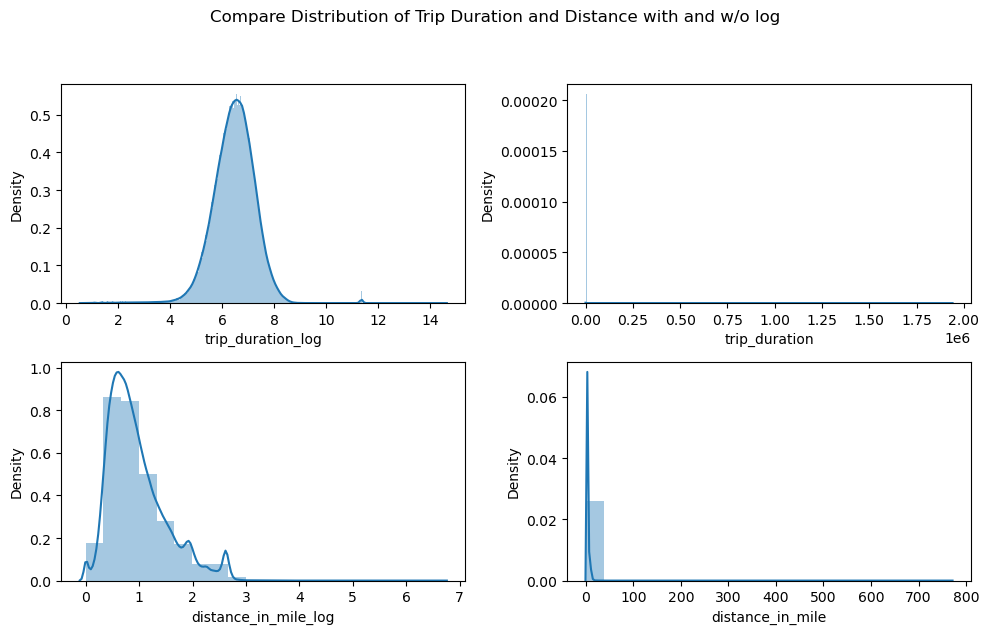

In [22]:
# Check the distribution of trip-duration and distance-in-mile (applying log and w/o log)

fig, axs = plt.subplots(nrows = 2, ncols=2, figsize = (10,6))

sns.distplot(nyc_taxi_trip_df['trip_duration_log'],    kde    = True, bins = 400, ax = axs[0,0])
sns.distplot(nyc_taxi_trip_df['trip_duration'], kde = True, bins = 400, ax = axs[0,1])

sns.distplot(nyc_taxi_trip_df['distance_in_mile_log'],    kde = True, bins = 20, ax = axs[1,0])
sns.distplot(nyc_taxi_trip_df['distance_in_mile'], kde = True, bins = 20, ax = axs[1,1])

fig.suptitle("Compare Distribution of Trip Duration and Distance with and w/o log", y=1.05)

plt.tight_layout()
plt.show()

Observations

- The majority of rides follow a rather smooth distribution having a peak just around exp(6.5)  i.e. about 17 minutes.
- There are several suspiciously short rides with less than 10 seconds duration.
- There are a few some outliers near 12.

In [23]:
nyc_taxi_trip_df.columns

Index(['id', 'vendor_id', 'pickup_datetime', 'dropoff_datetime',
       'passenger_count', 'pickup_longitude', 'pickup_latitude',
       'dropoff_longitude', 'dropoff_latitude', 'store_and_fwd_flag',
       'trip_duration', 'distance_in_mile', 'distance_range', 'pickup_hour',
       'pickup_minute', 'doy_of_pickup', 'doy_of_dropoff', 'dow_of_pickup',
       'dow_of_dropoff', 'day_of_pickup', 'day_of_dropoff', 'woy_of_pickup',
       'woy_of_dropoff', 'is_pickup_weekday', 'is_dropoff_weekday',
       'moy_of_pickup', 'moy_of_dropoff', 'trip_duration_log',
       'distance_in_mile_log'],
      dtype='object')

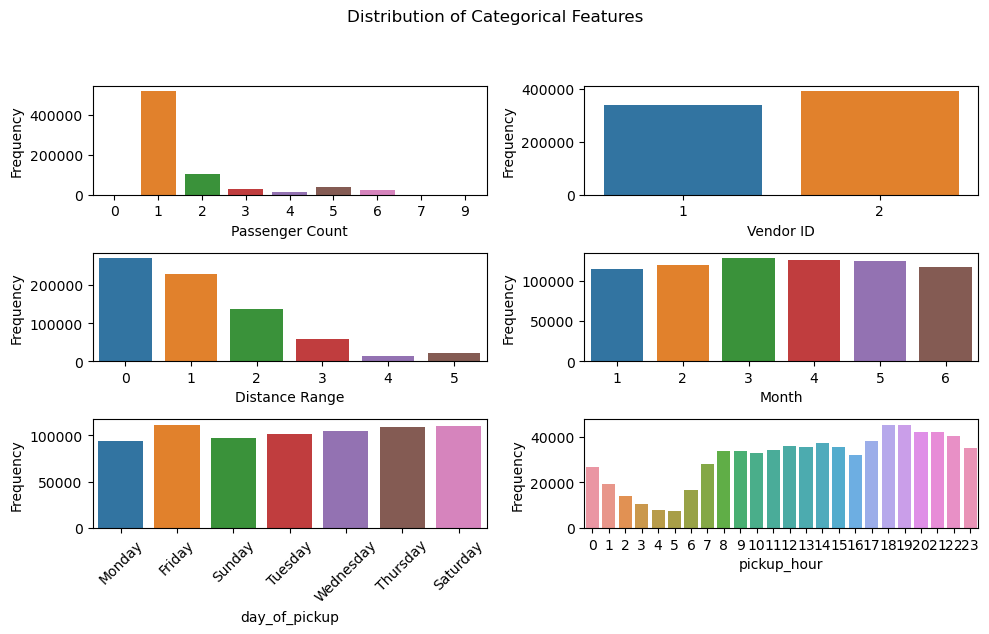

In [24]:
# Analyze Distribution of some Categorical Features

fig, axs = plt.subplots(nrows = 3, ncols=2, figsize = (10,6))

# Passenger Count
sns.countplot(data = nyc_taxi_trip_df, x = nyc_taxi_trip_df['passenger_count'], ax = axs[0,0])
axs[0,0].set_xlabel('Passenger Count')
axs[0,0].set_ylabel('Frequency')


# vendor_id
sns.countplot(data = nyc_taxi_trip_df, x = nyc_taxi_trip_df['vendor_id'], ax = axs[0,1])
axs[0,1].set_xlabel('Vendor ID')
axs[0,1].set_ylabel('Frequency')

# # store_and_fwd_flag
# plt.subplot(133)
sns.countplot(x = nyc_taxi_trip_df['distance_range'], ax = axs[1,0])
axs[1,0].set_xlabel('Distance Range')
axs[1,0].set_ylabel('Frequency')

# Is Weekday Count
sns.countplot(x = nyc_taxi_trip_df['moy_of_pickup'], ax = axs[1,1])
axs[1,1].set_xlabel('Month')
axs[1,1].set_ylabel('Frequency')

# Weekday Frequency
sns.countplot(x = nyc_taxi_trip_df['day_of_pickup'], ax = axs[2,0])
axs[2,0].set_ylabel('Frequency')
axs[2,0].tick_params(axis='x', labelrotation=45)

# Weekday Frequency
sns.countplot(x = nyc_taxi_trip_df['pickup_hour'], ax = axs[2,1])
axs[2,1].set_ylabel('Frequency')
axs[2,1].tick_params(axis='x')

fig.suptitle("Distribution of Categorical Features", y=1.05)

plt.tight_layout()

Lets look at the geospatial or location features to check consistency. They should not vary much as we are only considering trips within New York city.

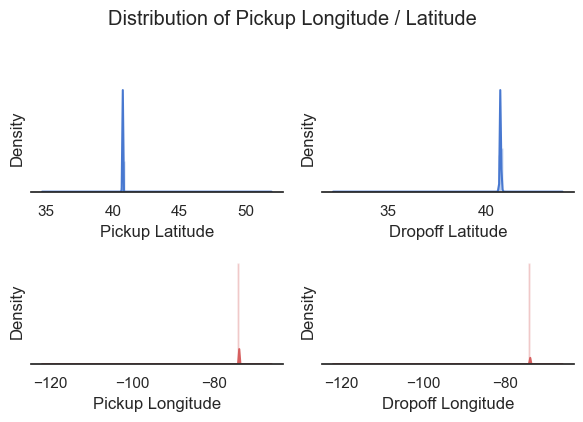

In [25]:
# Review Latitude and Longitude of Pickup Location

sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(6, 4))

sns.despine(left=True)
sns.distplot(nyc_taxi_trip_df['pickup_latitude'].values, label = 'pickup_latitude',color="b",bins = 100, ax=axes[0,0])
axes[0,0].set_xlabel('Pickup Latitude')

sns.distplot(nyc_taxi_trip_df['pickup_longitude'].values, label = 'pickup_longitude',color="r",bins =100, ax=axes[1,0])
axes[1,0].set_xlabel('Pickup Longitude')

sns.distplot(nyc_taxi_trip_df['dropoff_latitude'].values, label = 'dropoff_latitude',color="b",bins =100, ax=axes[0,1])
axes[0,1].set_xlabel('Dropoff Latitude')

sns.distplot(nyc_taxi_trip_df['dropoff_longitude'].values, label = 'dropoff_longitude',color="r",bins =100, ax=axes[1,1])
axes[1,1].set_xlabel('Dropoff Longitude')

plt.setp(axes, yticks=[])

f.suptitle("Distribution of Pickup Longitude / Latitude", y=1.05)

plt.tight_layout()
plt.show()

Observations for the Pickup/Dropoff

1. Pick and Drop-off latitude are centered around 40 to 41, and longitude are situated around -74 to -73. 
2. Some extreme co-ordinates has squeezed the plot such that we see a spike here
3. A good idea is to remove these outliers and look at the distribution more closely

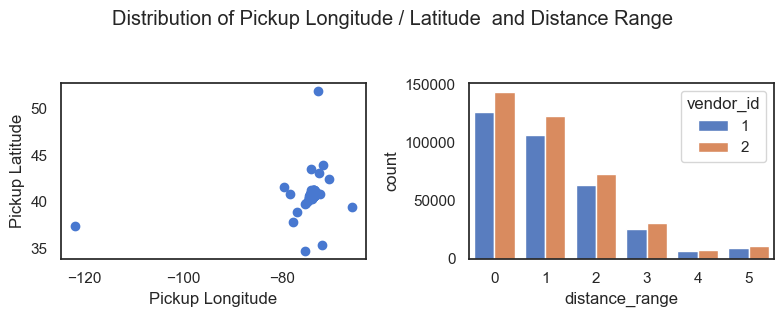

In [26]:
# Review distribution of Pickup Latitude and Longitude and distance_range

f, (ax0, ax1) = plt.subplots(1,2,figsize=(8, 3), sharex=False, sharey = False)#

ax0.scatter(x='pickup_longitude', y='pickup_latitude', data = nyc_taxi_trip_df)
ax0.set_xlabel('Pickup Longitude')
ax0.set_ylabel('Pickup Latitude')

sns.countplot(x = nyc_taxi_trip_df['distance_range'], hue = nyc_taxi_trip_df['vendor_id'], ax = ax1)

f.suptitle("Distribution of Pickup Longitude / Latitude  and Distance Range", y=1.05)

plt.tight_layout()

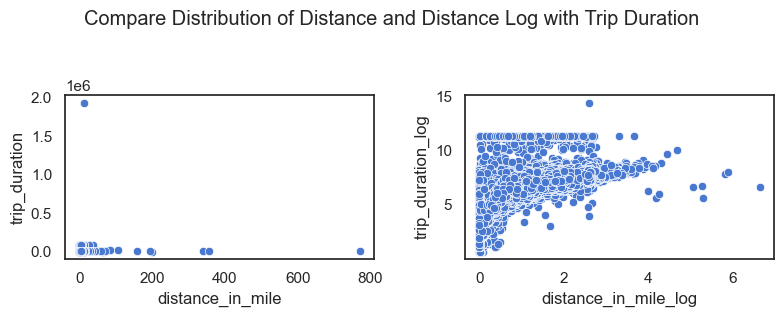

In [27]:
# Compare distribution of distance_in_mile and trip_duration (with and without log)

f, (ax0, ax1) = plt.subplots(1,2,figsize=(8, 3), sharex=False, sharey = False)#

sns.scatterplot(x = 'distance_in_mile', y = 'trip_duration', data = nyc_taxi_trip_df, ax = ax0)
sns.scatterplot(x = 'distance_in_mile_log', y = 'trip_duration_log', data = nyc_taxi_trip_df, ax = ax1)

f.suptitle("Compare Distribution of Distance and Distance Log with Trip Duration", y=1.05)

plt.tight_layout()

In [28]:
nyc_taxi_trip_df.shape

(729322, 29)

In [29]:
nyc_taxi_trip_df.loc[(nyc_taxi_trip_df.pickup_latitude > 40.6) & (nyc_taxi_trip_df.pickup_latitude < 40.9)].shape

(729175, 29)

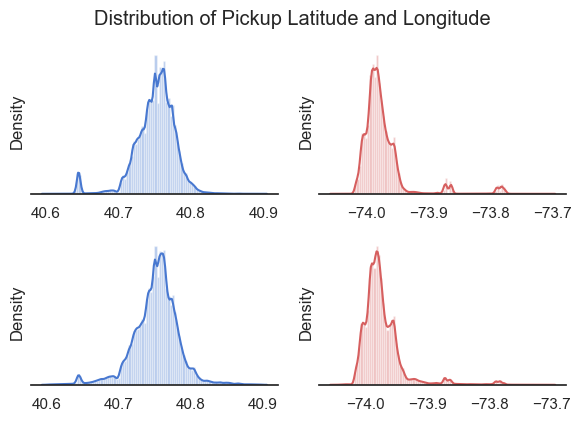

In [30]:
nyc_taxi_trip_df = nyc_taxi_trip_df.loc[(nyc_taxi_trip_df.pickup_latitude > 40.6) & 
                                        (nyc_taxi_trip_df.pickup_latitude < 40.9)]
nyc_taxi_trip_df = nyc_taxi_trip_df.loc[(nyc_taxi_trip_df.dropoff_latitude>40.6) & 
                                        (nyc_taxi_trip_df.dropoff_latitude < 40.9)]
nyc_taxi_trip_df = nyc_taxi_trip_df.loc[(nyc_taxi_trip_df.dropoff_longitude > -74.05) & 
                                        (nyc_taxi_trip_df.dropoff_longitude < -73.7)]
nyc_taxi_trip_df = nyc_taxi_trip_df.loc[(nyc_taxi_trip_df.pickup_longitude > -74.05) & 
                                        (nyc_taxi_trip_df.pickup_longitude < -73.7)]
nyc_taxi_trip_df_data_new = nyc_taxi_trip_df.copy()

sns.set(style="white", palette="muted", color_codes=True)
f, axes = plt.subplots(2,2,figsize=(6, 4), sharex=False, sharey = False)#
sns.despine(left=True)
sns.distplot(nyc_taxi_trip_df_data_new['pickup_latitude'].values, 
             label = 'pickup_latitude',color="b",bins = 100, ax=axes[0,0])
sns.distplot(nyc_taxi_trip_df_data_new['pickup_longitude'].values, 
             label = 'pickup_longitude',color="r",bins =100, ax=axes[0,1])
sns.distplot(nyc_taxi_trip_df_data_new['dropoff_latitude'].values, 
             label = 'dropoff_latitude',color="b",bins =100, ax=axes[1, 0])
sns.distplot(nyc_taxi_trip_df_data_new['dropoff_longitude'].values, 
             label = 'dropoff_longitude',color="r",bins =100, ax=axes[1, 1])
plt.setp(axes, yticks=[])
plt.tight_layout()

f.suptitle("Distribution of Pickup Latitude and Longitude", y=1.05)

plt.show()

In [31]:
nyc_taxi_trip_df.shape, nyc_taxi_trip_df_data_new.shape

((726195, 29), (726195, 29))

<Axes: xlabel='pickup_longitude', ylabel='pickup_latitude'>

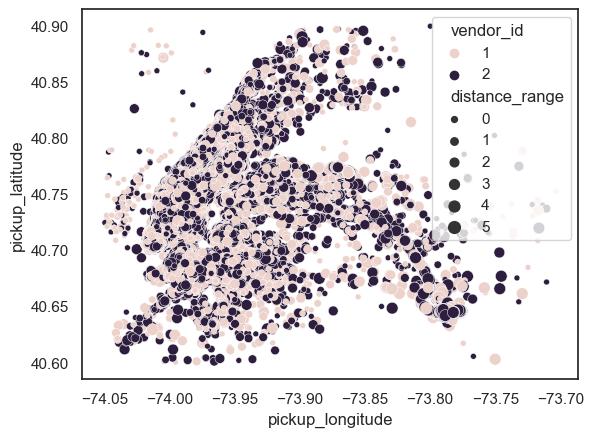

In [32]:
sns.set(style="white", palette="muted", color_codes=True)
sns.scatterplot(data = nyc_taxi_trip_df, x = 'pickup_longitude', y = 'pickup_latitude', 
                hue = 'vendor_id', size = 'distance_range')

In [33]:
# Remove constant features

nyc_taxi_trip_df.drop(['id', 'day_of_pickup', 'day_of_dropoff', 'store_and_fwd_flag'], axis = 1, inplace = True)

In [34]:
nyc_taxi_trip_df.columns

Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'trip_duration', 'distance_in_mile',
       'distance_range', 'pickup_hour', 'pickup_minute', 'doy_of_pickup',
       'doy_of_dropoff', 'dow_of_pickup', 'dow_of_dropoff', 'woy_of_pickup',
       'woy_of_dropoff', 'is_pickup_weekday', 'is_dropoff_weekday',
       'moy_of_pickup', 'moy_of_dropoff', 'trip_duration_log',
       'distance_in_mile_log'],
      dtype='object')

## 4. Feature Analysis

Now, we have seen the Exploration and a good understanding of data shape and structure. We also looked at firstly the basic tendency of data.

We can now look into feature analysis and the good model is built upon having good feature analysis and selection. 

### 4.1. Create an elbow curve to select the optimal number of clusters

K-means is somewhat naive - it clusters the data into k clusters, even if k is not the right number of clusters to use. When we come to clustering, it's hard to know how many clusters are optimal… In our dataset, how many clusters are optimal i.e. make sense, we don't want to guess now do we? Therefore, when using k-means clustering, we need a way to determine whether we are using the right number of clusters.

One method to validate the number of clusters is the elbow method. The idea of the elbow method is to run k-means clustering on the dataset for a range of values of k (say, k from 1 to 10), and for each value of k calculate the Sum of Squared Errors (SSE).

When K increases, the centroids are closer to the clusters centroids. The improvements will decline rapidly at some point, creating the elbow shape. That is the optimal value for K

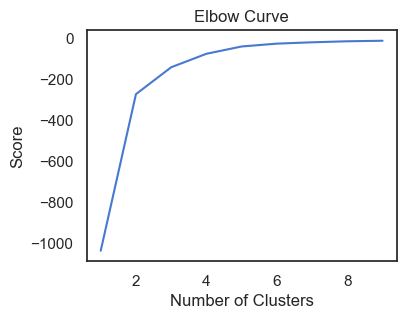

In [35]:
from sklearn.cluster import KMeans

Y_axis = nyc_taxi_trip_df[['pickup_latitude']]
X_axis = nyc_taxi_trip_df[['pickup_longitude']]

K_clusters = range(1,10)
kmeans = [KMeans(n_clusters=i) for i in K_clusters]

score = [kmeans[i].fit(X_axis).score(X_axis) for i in range(len(kmeans))]
# Visualize
plt.figure(figsize = (4,3))

plt.plot(K_clusters, score)
plt.xlabel('Number of Clusters')
plt.ylabel('Score')
plt.title('Elbow Curve')
plt.show()

### 4.2 Clustering using K-Means and Assigning Clusters to Data

In [36]:
nyc_taxi_trip_df.columns

Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'trip_duration', 'distance_in_mile',
       'distance_range', 'pickup_hour', 'pickup_minute', 'doy_of_pickup',
       'doy_of_dropoff', 'dow_of_pickup', 'dow_of_dropoff', 'woy_of_pickup',
       'woy_of_dropoff', 'is_pickup_weekday', 'is_dropoff_weekday',
       'moy_of_pickup', 'moy_of_dropoff', 'trip_duration_log',
       'distance_in_mile_log'],
      dtype='object')

In [37]:
nyc_taxi_trip_df.columns[4:6]

Index(['pickup_longitude', 'pickup_latitude'], dtype='object')

In [38]:
# Based on pick_up_longitude and latitude, create clusters and label each dataset record

kmeans = KMeans(n_clusters = 4, init ='k-means++')
kmeans.fit(nyc_taxi_trip_df[nyc_taxi_trip_df.columns[4:6]]) # Compute k-means clustering.

# Add new 'cluster_label' column to dataframe
nyc_taxi_trip_df['cluster_label'] = kmeans.fit_predict(nyc_taxi_trip_df[nyc_taxi_trip_df.columns[4:6]])
centers = kmeans.cluster_centers_ # Coordinates of cluster centers.
labels = kmeans.predict(nyc_taxi_trip_df[nyc_taxi_trip_df.columns[4:6]]) # Labels of each point

nyc_taxi_trip_df.head()

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration,distance_in_mile,...,dow_of_dropoff,woy_of_pickup,woy_of_dropoff,is_pickup_weekday,is_dropoff_weekday,moy_of_pickup,moy_of_dropoff,trip_duration_log,distance_in_mile_log,cluster_label
0,2,736023,736023,1,-73.953918,40.778873,-73.963875,40.771164,400,0.745070,...,1,9,9,1,1,2,2,5.993961,0.556795,2
1,1,736034,736034,2,-73.988312,40.731743,-73.994751,40.694931,1100,2.565714,...,5,10,10,1,1,3,3,7.003974,1.271364,0
2,2,736015,736015,2,-73.997314,40.721458,-73.948029,40.774918,1635,4.505415,...,7,7,7,0,0,2,2,7.400010,1.705732,0
3,2,735968,735968,6,-73.961670,40.759720,-73.956779,40.780628,1141,1.467120,...,2,1,1,1,1,1,1,7.040536,0.903051,2
4,1,736011,736011,1,-74.017120,40.708469,-73.988182,40.740631,848,2.689630,...,3,7,7,1,1,2,2,6.744059,1.305526,0


<Axes: xlabel='pickup_longitude', ylabel='pickup_latitude'>

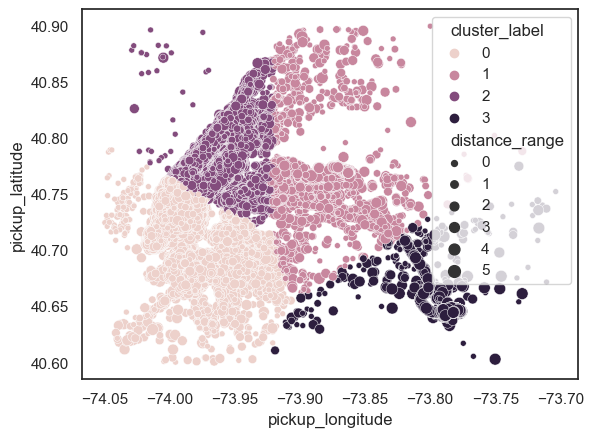

In [39]:
# Review the distribution of clusters based on pick_up_latitude and longitude

sns.scatterplot(data = nyc_taxi_trip_df, x = 'pickup_longitude', y = 'pickup_latitude', 
                hue = 'cluster_label', size = 'distance_range')

Text(0.5, 1.05, 'Distribution of Cluster Label and Month of Year by Distance')

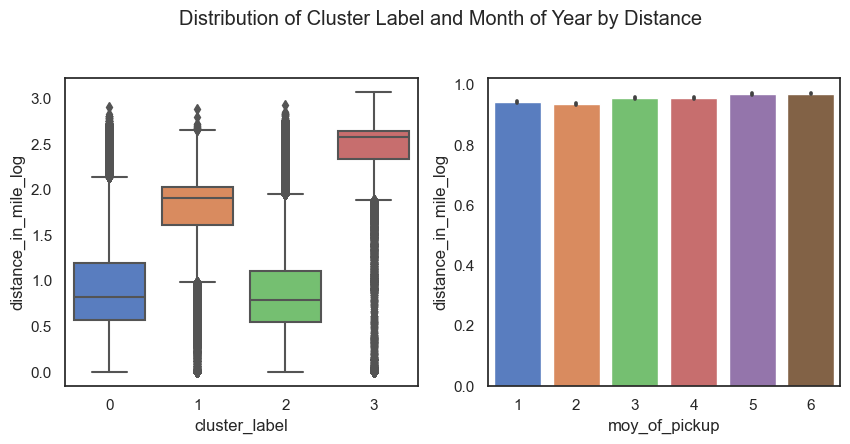

In [40]:
# Review distribution of cluster label and month by distance_in_mile

f, (ax0, ax1) = plt.subplots(1,2,figsize=(10, 4))#

sns.boxplot(x = nyc_taxi_trip_df['cluster_label'], y = nyc_taxi_trip_df['distance_in_mile_log'], ax = ax0)
sns.barplot(x = nyc_taxi_trip_df['moy_of_pickup'], y = nyc_taxi_trip_df['distance_in_mile_log'], ax = ax1)

f.suptitle("Distribution of Cluster Label and Month of Year by Distance", y=1.05)

## 5. Feature Selection

### 5.1 Correlation of Independent Featues

In [41]:
nyc_df_cols = nyc_taxi_trip_df.columns
nyc_df_cols

Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'trip_duration', 'distance_in_mile',
       'distance_range', 'pickup_hour', 'pickup_minute', 'doy_of_pickup',
       'doy_of_dropoff', 'dow_of_pickup', 'dow_of_dropoff', 'woy_of_pickup',
       'woy_of_dropoff', 'is_pickup_weekday', 'is_dropoff_weekday',
       'moy_of_pickup', 'moy_of_dropoff', 'trip_duration_log',
       'distance_in_mile_log', 'cluster_label'],
      dtype='object')

In [42]:
# Remove Target Varible 'Trip Duration ' and 'Trip Duration Log'
# create Target variable using 'Trip Duration Log'

X_data = nyc_taxi_trip_df.drop(['trip_duration', 'trip_duration_log'], axis = 1)
y_data = nyc_taxi_trip_df['trip_duration_log']

corr_matrix = X_data.corr().abs()
corr_matrix = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool_))
corr_matrix

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance_in_mile,distance_range,...,dow_of_pickup,dow_of_dropoff,woy_of_pickup,woy_of_dropoff,is_pickup_weekday,is_dropoff_weekday,moy_of_pickup,moy_of_dropoff,distance_in_mile_log,cluster_label
vendor_id,NaN,0.005277,0.005253,0.286814,0.016870,0.005430,0.006752,0.007084,0.008497,0.007854,...,0.000924,0.001034,0.001195,0.001240,0.002755,0.002795,0.005418,0.005393,0.007385,0.013191
pickup_datetime,NaN,NaN,0.999998,0.001242,0.006148,0.003316,0.008780,0.002767,0.018340,0.021349,...,0.012504,0.012199,0.713526,0.714174,0.006620,0.006784,0.985659,0.985658,0.021604,0.001256
dropoff_datetime,NaN,NaN,NaN,0.001228,0.006197,0.003396,0.008827,0.002821,0.018486,0.021504,...,0.012481,0.012136,0.713525,0.714171,0.006616,0.006728,0.985657,0.985660,0.021762,0.001287
passenger_count,NaN,NaN,NaN,NaN,0.002970,0.004082,0.000920,0.002881,0.011017,0.009746,...,0.025880,0.026070,0.004929,0.004889,0.030170,0.030391,0.001543,0.001559,0.010601,0.000483
pickup_longitude,NaN,NaN,NaN,NaN,NaN,0.143544,0.270320,0.041146,0.521461,0.409431,...,0.028683,0.030106,0.011553,0.011417,0.023031,0.024076,0.006317,0.006414,0.402412,0.504420
pickup_latitude,NaN,NaN,NaN,NaN,NaN,NaN,0.054679,0.433468,0.320967,0.253297,...,0.035210,0.035419,0.007204,0.007204,0.041343,0.041850,0.002196,0.002278,0.244236,0.429947
dropoff_longitude,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.098747,0.422810,0.367438,...,0.001388,0.001331,0.013496,0.013523,0.004341,0.004246,0.008751,0.008804,0.365204,0.212345
dropoff_latitude,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.161403,0.140657,...,0.024073,0.024518,0.003119,0.003123,0.026120,0.026555,0.001570,0.001620,0.134766,0.307258
distance_in_mile,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.918334,...,0.008858,0.009265,0.023379,0.023313,0.011746,0.012459,0.017549,0.017742,0.932284,0.126430
distance_range,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,0.019181,0.019895,0.026254,0.026206,0.022592,0.023706,0.020355,0.020545,0.966612,0.079265


In [43]:
corr_matrix_sorted = corr_matrix.unstack().sort_values(ascending=False)
corr_cols = corr_matrix.columns
corr_cols

Index(['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'passenger_count',
       'pickup_longitude', 'pickup_latitude', 'dropoff_longitude',
       'dropoff_latitude', 'distance_in_mile', 'distance_range', 'pickup_hour',
       'pickup_minute', 'doy_of_pickup', 'doy_of_dropoff', 'dow_of_pickup',
       'dow_of_dropoff', 'woy_of_pickup', 'woy_of_dropoff',
       'is_pickup_weekday', 'is_dropoff_weekday', 'moy_of_pickup',
       'moy_of_dropoff', 'distance_in_mile_log', 'cluster_label'],
      dtype='object')

In [44]:
corr_matrix_sorted.head()

doy_of_dropoff    dropoff_datetime    1.000000
doy_of_pickup     pickup_datetime     1.000000
doy_of_dropoff    doy_of_pickup       0.999998
doy_of_pickup     dropoff_datetime    0.999998
dropoff_datetime  pickup_datetime     0.999998
dtype: float64

In [45]:
len(corr_matrix_sorted)

576

In [46]:
# Choose correlation factor and check out features

corr_matrix[corr_matrix[corr_cols] > 0.7]

,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,distance_in_mile,distance_range,...,dow_of_pickup,dow_of_dropoff,woy_of_pickup,woy_of_dropoff,is_pickup_weekday,is_dropoff_weekday,moy_of_pickup,moy_of_dropoff,distance_in_mile_log,cluster_label
vendor_id,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pickup_datetime,NaN,NaN,0.999998,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.713526,0.714174,NaN,NaN,0.985659,0.985658,NaN,NaN
dropoff_datetime,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,0.713525,0.714171,NaN,NaN,0.985657,0.985660,NaN,NaN
passenger_count,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pickup_longitude,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
pickup_latitude,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dropoff_longitude,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
dropoff_latitude,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN
distance_in_mile,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.918334,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.932284,NaN
distance_range,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.966612,NaN


In [47]:
# List all the variables having correlation greater than 0.7

cols_to_drop = [column for column in corr_matrix.columns if any(corr_matrix[corr_cols] > 0.7)]
cols_to_drop

['vendor_id',
 'pickup_datetime',
 'dropoff_datetime',
 'passenger_count',
 'pickup_longitude',
 'pickup_latitude',
 'dropoff_longitude',
 'dropoff_latitude',
 'distance_in_mile',
 'distance_range',
 'pickup_hour',
 'pickup_minute',
 'doy_of_pickup',
 'doy_of_dropoff',
 'dow_of_pickup',
 'dow_of_dropoff',
 'woy_of_pickup',
 'woy_of_dropoff',
 'is_pickup_weekday',
 'is_dropoff_weekday',
 'moy_of_pickup',
 'moy_of_dropoff',
 'distance_in_mile_log',
 'cluster_label']

In [48]:
# Modify the list with minor changes

cols_to_drop = ['vendor_id', 'pickup_datetime', 'dropoff_datetime', 'dropoff_longitude',
                 'distance_in_mile', 'dropoff_latitude', 'distance_range', 'pickup_hour', 'pickup_minute',
                 'doy_of_pickup', 'doy_of_dropoff', 'dow_of_pickup', 'woy_of_pickup', 'woy_of_dropoff',
                 'dow_of_dropoff', 'is_pickup_weekday', 'moy_of_pickup', 'moy_of_dropoff']

In [49]:
# Shape of data before dropping the selected features

X_data.shape

(726195, 24)

In [50]:
# Drop the selected features and review the shape of X_data

X_data = X_data.drop(X_data[cols_to_drop], axis=1)
X_data_cols = X_data.columns
X_data.shape, X_data_cols

((726195, 6),
 Index(['passenger_count', 'pickup_longitude', 'pickup_latitude',
        'is_dropoff_weekday', 'distance_in_mile_log', 'cluster_label'],
       dtype='object'))

<Figure size 800x600 with 0 Axes>

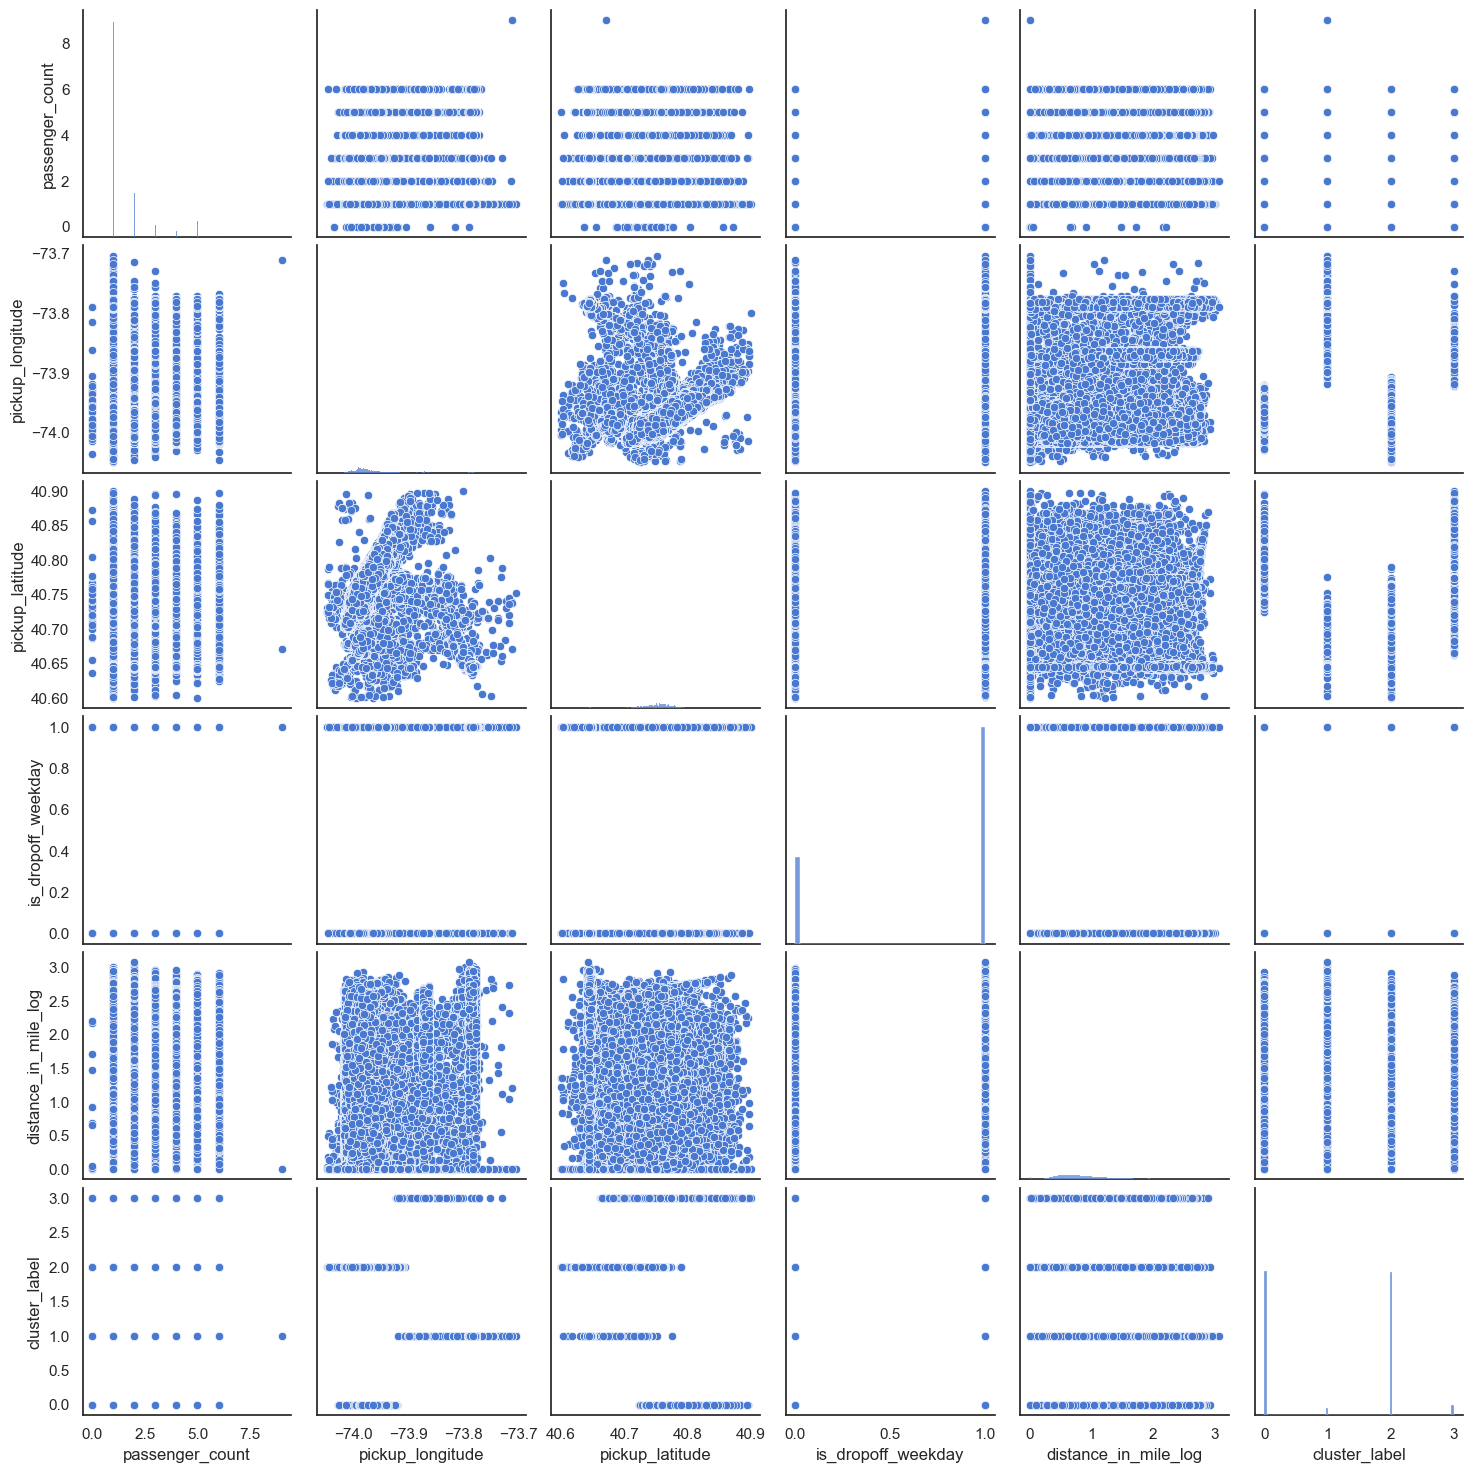

In [82]:
# Review the data relationships using pairplot amongst all independent features 

plt.figure(figsize = (8,6))
sns.pairplot(X_data)

##### Understanding Data: Exploratory Data Analysis 

Calculating Correlation, P-value and Regression plot

To understand the spread of datapoints this regression plot has been plotted along with pearson coefficients.

In [51]:
X_data.shape, X_data_cols

((726195, 6),
 Index(['passenger_count', 'pickup_longitude', 'pickup_latitude',
        'is_dropoff_weekday', 'distance_in_mile_log', 'cluster_label'],
       dtype='object'))

The Pearson Correlation Coefficient of 'Cluster Label' is  0.10817741247611523  with a P-value of P = 0.0
The Pearson Correlation Coefficient of 'Passenger Count' is  0.020679292491154536  with a P-value of P = 1.6078830869548145e-69
The Pearson Correlation Coefficient of 'Pickup Longitude' is  0.20476379421709373  with a P-value of P = 0.0
The Pearson Correlation Coefficient of 'Distance' is  0.7394753021591693  with a P-value of P = 0.0


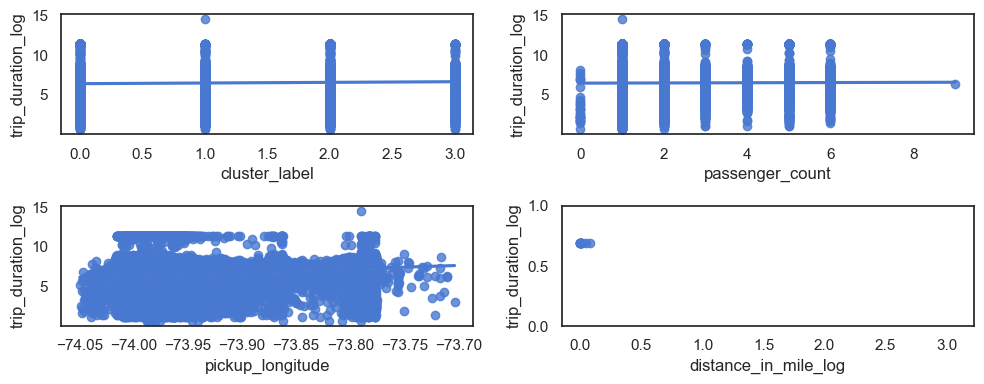

In [85]:
fig, ((ax0, ax1), (ax2, ax3)) = plt.subplots(2,2,figsize=(10, 4))#

pearson_coef, p_value = stats.pearsonr(nyc_taxi_trip_df['cluster_label'], nyc_taxi_trip_df['trip_duration_log'])
print("The Pearson Correlation Coefficient of 'Cluster Label' is ", pearson_coef, " with a P-value of P =", p_value)  
sns.regplot(x=nyc_taxi_trip_df['cluster_label'], y=nyc_taxi_trip_df['trip_duration_log'], data=nyc_taxi_trip_df, ax = ax0)
plt.ylim(0,)

pearson_coef, p_value = stats.pearsonr(nyc_taxi_trip_df['passenger_count'], nyc_taxi_trip_df['trip_duration_log'])
print("The Pearson Correlation Coefficient of 'Passenger Count' is ", pearson_coef, " with a P-value of P =", p_value)  
sns.regplot(x=nyc_taxi_trip_df['passenger_count'], y=nyc_taxi_trip_df['trip_duration_log'], data=nyc_taxi_trip_df, ax = ax1)
plt.ylim(0,)

pearson_coef, p_value = stats.pearsonr(nyc_taxi_trip_df['pickup_longitude'], nyc_taxi_trip_df['trip_duration_log'])
print("The Pearson Correlation Coefficient of 'Pickup Longitude' is ", pearson_coef, " with a P-value of P =", p_value)  
sns.regplot(x=nyc_taxi_trip_df['pickup_longitude'], y=nyc_taxi_trip_df['trip_duration_log'], data=nyc_taxi_trip_df, ax = ax2)
plt.ylim(0,)

pearson_coef, p_value = stats.pearsonr(nyc_taxi_trip_df['distance_in_mile_log'], nyc_taxi_trip_df['trip_duration_log'])
print("The Pearson Correlation Coefficient of 'Distance' is ", pearson_coef, " with a P-value of P =", p_value)  
sns.regplot(x=nyc_taxi_trip_df['distance_in_mile_log'], y=nyc_taxi_trip_df['trip_duration_log'], data=nyc_taxi_trip_df, ax = ax3)
plt.ylim(0,)

plt.tight_layout()

## 6. Model Building

### 6.1 Plotting Decision Tree without using any external tool for Optimization such as Grid Search CV

In [114]:
# Import Sklearn Libraries and Scale the X_data before split to Train

import sklearn
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import PolynomialFeatures
from sklearn.preprocessing import scale
from sklearn.feature_selection import RFE
from sklearn.tree import DecisionTreeRegressor
from sklearn import tree
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import KFold
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import cross_val_predict
from sklearn import metrics
from sklearn.metrics import mean_absolute_error as mae
from sklearn.metrics import r2_score, explained_variance_score, mean_squared_error
from statsmodels.graphics.gofplots import qqplot
from sklearn.feature_selection import RFE
import math

import warnings # supress warnings
warnings.filterwarnings('ignore')

In [53]:
X_data.columns, X_data.shape, y_data.shape

(Index(['passenger_count', 'pickup_longitude', 'pickup_latitude',
        'is_dropoff_weekday', 'distance_in_mile_log', 'cluster_label'],
       dtype='object'),
 (726195, 6),
 (726195,))

In [54]:
# split into train and test

X_train, X_test, y_train, y_test = train_test_split(X_data, y_data, test_size=0.30, random_state=4)
X_train_cols = X_train.columns
X_train_cols

Index(['passenger_count', 'pickup_longitude', 'pickup_latitude',
       'is_dropoff_weekday', 'distance_in_mile_log', 'cluster_label'],
      dtype='object')

In [55]:
X_train.head()

,passenger_count,pickup_longitude,pickup_latitude,is_dropoff_weekday,distance_in_mile_log,cluster_label
474616,2,-73.948471,40.782631,1,0.959741,2
424315,1,-73.988922,40.730495,1,0.579118,0
151771,1,-73.733368,40.675198,1,0.000000,3
288843,1,-73.995346,40.717789,0,0.927165,0
446272,1,-73.954468,40.764057,1,1.324919,2


In [56]:
# Review the shape of Train and Test data afer split

X_train.shape, X_test.shape, y_train.shape, y_test.shape

((508336, 6), (217859, 6), (508336,), (217859,))

### 6.2 Standardize and Apply Decision Tree algorithm for regression

In [57]:
# Now scale the X data using MinMaxScalar

scaler         = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled  = scaler.transform(X_test)

X_train_scaled = pd.DataFrame(X_train_scaled, columns = X_train_cols)
X_test_scaled  = pd.DataFrame(X_test_scaled,  columns = X_train_cols)

In [58]:
X_train_scaled.shape, X_test_scaled.shape, y_train.shape, y_test.shape

((508336, 6), (217859, 6), (508336,), (217859,))

[Text(0, 0, 'passenger_count'),
 Text(1, 0, 'pickup_longitude'),
 Text(2, 0, 'pickup_latitude'),
 Text(3, 0, 'is_dropoff_weekday'),
 Text(4, 0, 'distance_in_mile_log'),
 Text(5, 0, 'cluster_label')]

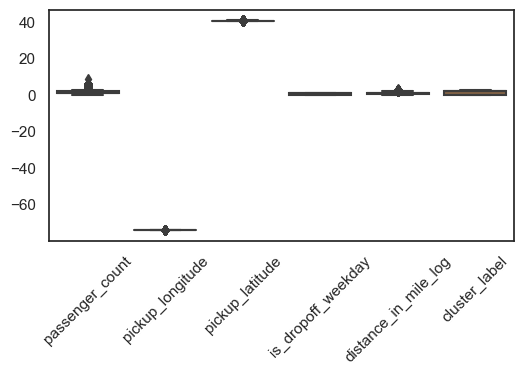

In [59]:
fig, ax = plt.subplots(figsize=(6, 3))

sns.boxplot(X_train, ax = ax)
ax.set_xticklabels(labels = X_train_cols, rotation=45)

[Text(0, 0, 'passenger_count'),
 Text(1, 0, 'pickup_longitude'),
 Text(2, 0, 'pickup_latitude'),
 Text(3, 0, 'is_dropoff_weekday'),
 Text(4, 0, 'distance_in_mile_log'),
 Text(5, 0, 'cluster_label')]

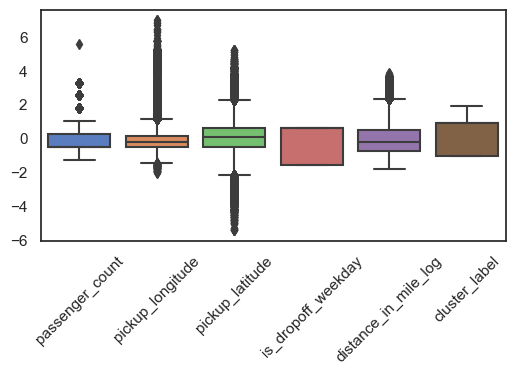

In [60]:
fig, ax = plt.subplots(figsize=(6, 3))

sns.boxplot(X_train_scaled, ax = ax)
ax.set_xticklabels(labels = X_train_cols, rotation=45)

In [61]:
# Import DecisionTreeRegressor from sklearn.tree

from sklearn.tree import DecisionTreeRegressor

# Instantiate dt
dt = DecisionTreeRegressor(max_depth=4, min_samples_leaf=0.13, random_state=3)

# Fit dt to the training set
dt.fit(X_train_scaled, y_train)

DecisionTreeRegressor(max_depth=4, min_samples_leaf=0.13, random_state=3)

### 6.3 Make predictions and evaluate output.

In [62]:
predictions = dt.predict(X_test_scaled)

df=pd.DataFrame({'Actual':y_test, 'Predicted':predictions})
df.head(5)

,Actual,Predicted
80622,7.082549,7.355290
368562,6.444131,6.032410
231292,7.130099,6.595268
183885,7.639642,7.355290
289927,6.740519,5.537900


### 6.4 Evaluating the Prediction Accuracy

In [63]:
from sklearn import metrics

# Predicting over the Train Set and calculating accuracy and error
y_train_predict = dt.predict(X_train_scaled)
mae_train       = mae(y_train, y_train_predict)
mse_train       = mean_squared_error(y_train, y_train_predict)
train_r2_sore  = r2_score(y_train, y_train_predict)

# Predicting over the Test Set and calculating accuracy and error
y_test_predict  = dt.predict(X_test_scaled)
mae_test        = mae(y_test, y_test_predict)
mse_test        = mean_squared_error(y_test, y_test_predict)
test_r2_sore  = r2_score(y_test, y_test_predict)

In [64]:
print("\nTrain MAE: ", mae_train)
print("Test MAE: ", mae_test)

print("\nTrain MSE: ", mse_train)
print("Test MSE: ", mse_test)

print("\nTrain RMSE  : ", math.sqrt(mse_train))
print("Test RMSE   : ", math.sqrt(mse_test))

print("\nTrain R2 Score  : ", train_r2_sore)
print("Test R2 Score  : ", test_r2_sore)



Train MAE:  0.3783034262033492
Test MAE:  0.37863727785435547

Train MSE:  0.2818320994315922
Test MSE:  0.2864310537295965

Train RMSE  :  0.530878610825104
Test RMSE   :  0.5351925389330427

Train R2 Score  :  0.5477388467100646
Test R2 Score  :  0.5428697819549203


### 6.5 Looking after Feature Importances

In [65]:
dt.feature_importances_

pd.Series(dt.feature_importances_,index=X_test_scaled.columns).sort_values(ascending=False)

distance_in_mile_log    1.0
passenger_count         0.0
pickup_longitude        0.0
pickup_latitude         0.0
is_dropoff_weekday      0.0
cluster_label           0.0
dtype: float64

#### Importing Graphviz from Sklearn library to plot the decission tree

In [66]:
from sklearn.tree import export_graphviz

dot_data = export_graphviz(dt, filled=True, rounded=True, feature_names=X_train_scaled.columns, out_file=None)

In [67]:
# import graphviz

# graphviz.Source(dot_data)

##  7.0 Using  Gridsearch & Cross Validation appropriately.

### 7.1 Import GridSearchCV and find CV results

In [88]:
from sklearn.model_selection import GridSearchCV

param_grid = [{"max_depth":[3,4,5, None], "max_features":[2,3,4,5,6]}]
gs = GridSearchCV(estimator=DecisionTreeRegressor(random_state=123),param_grid = param_grid,cv=10)
gs.fit(X_train_scaled, y_train)

gs.cv_results_['params']

[{'max_depth': 3, 'max_features': 2},
 {'max_depth': 3, 'max_features': 3},
 {'max_depth': 3, 'max_features': 4},
 {'max_depth': 3, 'max_features': 5},
 {'max_depth': 3, 'max_features': 6},
 {'max_depth': 4, 'max_features': 2},
 {'max_depth': 4, 'max_features': 3},
 {'max_depth': 4, 'max_features': 4},
 {'max_depth': 4, 'max_features': 5},
 {'max_depth': 4, 'max_features': 6},
 {'max_depth': 5, 'max_features': 2},
 {'max_depth': 5, 'max_features': 3},
 {'max_depth': 5, 'max_features': 4},
 {'max_depth': 5, 'max_features': 5},
 {'max_depth': 5, 'max_features': 6},
 {'max_depth': None, 'max_features': 2},
 {'max_depth': None, 'max_features': 3},
 {'max_depth': None, 'max_features': 4},
 {'max_depth': None, 'max_features': 5},
 {'max_depth': None, 'max_features': 6}]

In [120]:
gs.cv_results_['rank_test_score']

array([20, 12,  9,  8,  6, 14, 11,  7, 10,  3, 13,  5,  4,  2,  1, 15, 16,
       17, 18, 19])

In [121]:
gs.best_estimator_

DecisionTreeRegressor(max_depth=5, max_features=6, random_state=123)

### 7.2 Rerun DecisionTree Regressor based on Best Estimator

In [122]:
best_tree = DecisionTreeRegressor(max_depth=5,max_features=6, random_state=123)
best_tree.fit(X_train_scaled, y_train)
predictions = best_tree.predict(X_test_scaled)
df=pd.DataFrame({'Actual':y_test, 'Predicted':predictions})
df.head(5) #Check the top 5 predictions and actual values.

,Actual,Predicted
80622,7.082549,7.056000
368562,6.444131,5.998244
231292,7.130099,6.573035
183885,7.639642,7.446959
289927,6.740519,5.832476


In [124]:
print('Mean Absolute Error    :', metrics.mean_absolute_error(y_test,predictions))
print('Mean Squared Error     :', metrics.mean_squared_error(y_test,predictions))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_test,predictions)))
print('r2_score               :', metrics.r2_score(y_test,predictions))

Mean Absolute Error    : 0.3529219574603878
Mean Squared Error     : 0.2510310728136253
Root Mean Squared Error: 0.5010300118891335
r2_score               : 0.5993664529136022


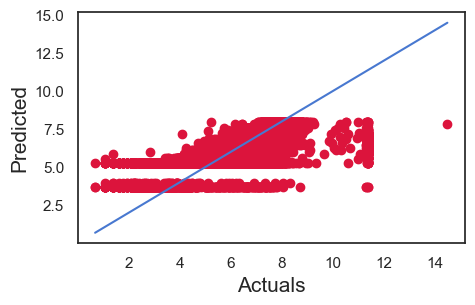

In [131]:
plt.figure(figsize=(5,3))

plt.scatter(y_test, predictions, c='crimson')

p1 = max(max(predictions), max(y_test))
p2 = min(min(predictions), min(y_test))
plt.plot([p1, p2], [p1, p2], 'b-')
plt.xlabel('Actuals', fontsize=15)
plt.ylabel('Predicted', fontsize=15)

plt.show()

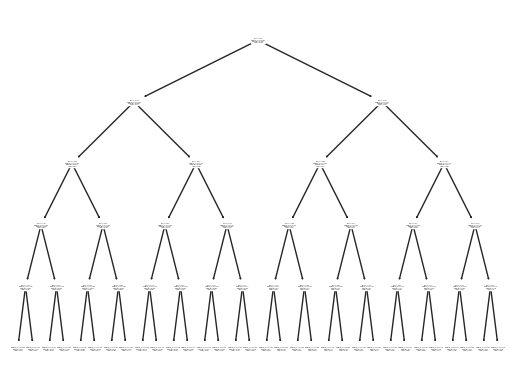

In [119]:
tree.plot_tree(best_tree)
plt.show()